# Arima model example: stationary series

This notebook describes the application of a Box-Jenkins approach to create an ARIMA model for a time series. The idea is to duplicate the procedure here described for other datasets.

In [2]:
%matplotlib inline
%reload_ext rpy2.ipython

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from pathlib import Path
from sklearn import metrics, model_selection

from fbprophet import Prophet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
dataset_root = Path('/home/ispmarin/profissional/projetos/ts_arima/data')
dataset = 'f_series.csv'

data_path = dataset_root / dataset

df = pd.read_csv(data_path)
date_index = pd.date_range('2015-01-01', periods=len(df))
df = df.set_index(date_index)
df.y = df.y.astype(float)

In [46]:
def check_adfuller(df, col):
    result = sm.tsa.stattools.adfuller(df[col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### First step: Run sequence plot
The run sequence plot is a standard plot of the time series sequence. 


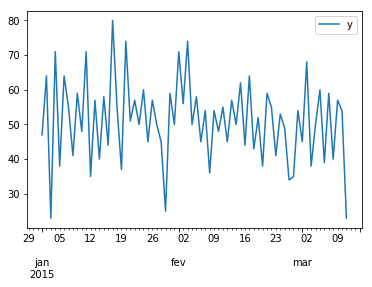

In [16]:
df.plot()

There is a variation on the data

### Second step: Run Autocorrelation plot

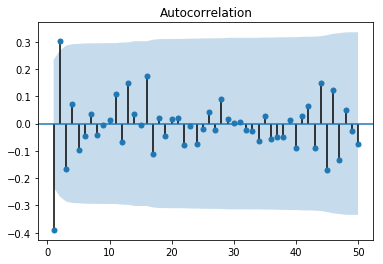

In [17]:
fig = sm.graphics.tsa.plot_acf(df, lags=50, zero=False)

Plot indicates that the series is stationary and with AR = 2.

### Series differentiation

There is no need to differentiate this series.

In [47]:
check_adfuller(df, 'y')

ADF Statistic: -5.376313
p-value: 0.000004
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


### Partial autocorrelation of differentiated series

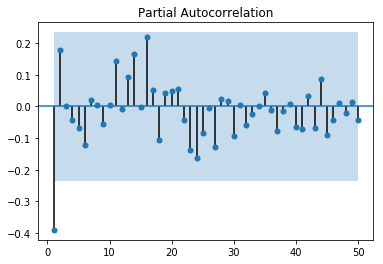

In [18]:
fig = sm.graphics.tsa.plot_pacf(df, lags=50, zero=False)

There is one large lag on the first order, indicating a model without MA terms or with MA = 1.

## Model fit

In [23]:
mdl_200 = sm.tsa.ARIMA(df, (2,0,0)).fit()
mdl_201 = sm.tsa.ARIMA(df, (2,0,1)).fit()

In [24]:
mdl_200.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(2, 0)   Log Likelihood                -264.829
Method:                       css-mle   S.D. of innovations             10.617
Date:                sex, 20 abr 2018   AIC                            537.657
Time:                        17:49:31   BIC                            546.651
Sample:                    01-01-2015   HQIC                           541.230
                         - 03-11-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.2263      1.101     46.537      0.000      49.069      53.384
ar.L1.y       -0.3407      0.122     -2.798      0.007      -0.579      -0.102
ar.L2.y        0.1873      0.122      1.531      0.130      -0.052       0.427
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5736           +0.0000j            1.5736            0.5000
AR.2            3.3923           +0.0000j            3.3923            0.0000
-----------------------------------------------------------------------------
"""

In [25]:
mdl_201.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(2, 1)   Log Likelihood                -264.827
Method:                       css-mle   S.D. of innovations             10.617
Date:                sex, 20 abr 2018   AIC                            539.654
Time:                        17:49:31   BIC                            550.896
Sample:                    01-01-2015   HQIC                           544.119
                         - 03-11-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.2240      1.107     46.254      0.000      49.053      53.395
ar.L1.y       -0.3108      0.502     -0.619      0.538      -1.295       0.674
ar.L2.y        0.1998      0.234      0.855      0.396      -0.258       0.658
ma.L1.y       -0.0312      0.509     -0.061      0.951      -1.030       0.967
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5909           +0.0000j            1.5909            0.5000
AR.2            3.1468           +0.0000j            3.1468            0.0000
MA.1           32.0834           +0.0000j           32.0834            0.0000
-----------------------------------------------------------------------------
"""

## Prediction

2015-03-12    61.362823
2015-03-13    42.484883
2015-03-14    56.103505
2015-03-15    47.927007
2015-03-16    53.264070
2015-03-17    49.913934
2015-03-18    52.055178
2015-03-19    50.698036
2015-03-20    51.561559
2015-03-21    51.013108
2015-03-22    51.361738
Freq: D, dtype: float64

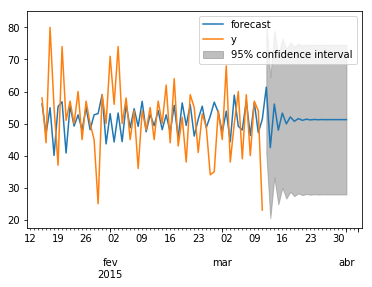

In [54]:
_ = mdl_200.plot_predict(start='2015-01-15', end='2015-04-01')
mdl_200.predict(start=70, end=80)

2015-03-12    61.362823
2015-03-13    42.484883
2015-03-14    56.103505
2015-03-15    47.927007
2015-03-16    53.264070
2015-03-17    49.913934
2015-03-18    52.055178
2015-03-19    50.698036
2015-03-20    51.561559
2015-03-21    51.013108
2015-03-22    51.361738
Freq: D, dtype: float64

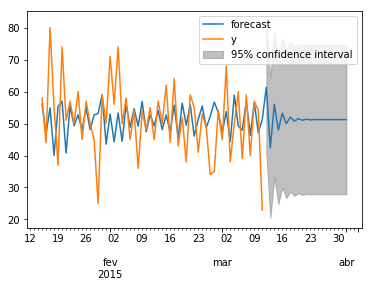

In [55]:
_ = mdl_201.plot_predict(start='2015-01-15', end='2015-04-01')
mdl_200.predict(start=70, end=80)

### Error evaluation

In [35]:
def ts_splitter(df, test_size = 0.3):
    index_split = int(np.floor(len(df)*(1-test_size)))
    return df.iloc[:index_split], df.iloc[index_split:]

In [36]:
df_train, df_test = ts_splitter(df,0.3)

135.95884117503633


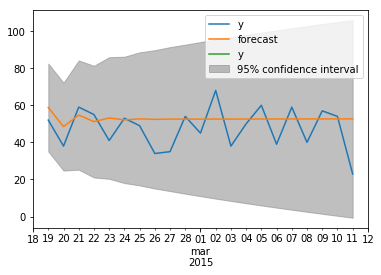

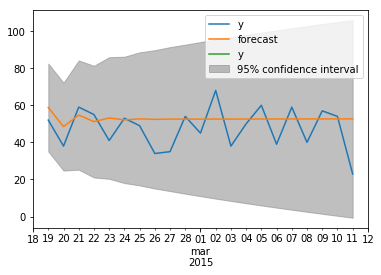

In [37]:
mdl_err = sm.tsa.ARIMA(df_train, (2,0,0)).fit()
y_hat = mdl_err.predict(start=df_test.index.min(), end=df_test.index.max(), typ='levels')
print(metrics.mean_squared_error(df_test.y.values, y_hat.values))
ax = df_test.plot()
mdl_err.plot_predict(start=df_test.index.min(), end=df_test.index.max(),ax=ax)

140.70225095587156


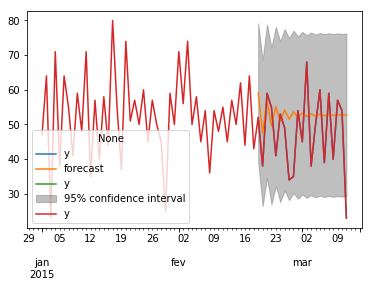

In [40]:
mdl_err = sm.tsa.ARIMA(df_train, (2,0,1)).fit()
y_hat = mdl_err.predict(start=df_test.index.min(), end=df_test.index.max())
print(metrics.mean_squared_error(df_test.y.values, y_hat.values))
ax = df_test.plot()
mdl_err.plot_predict(start=df_test.index.min(), end=df_test.index.max(),ax=ax)
df.plot(ax=ax)

# Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


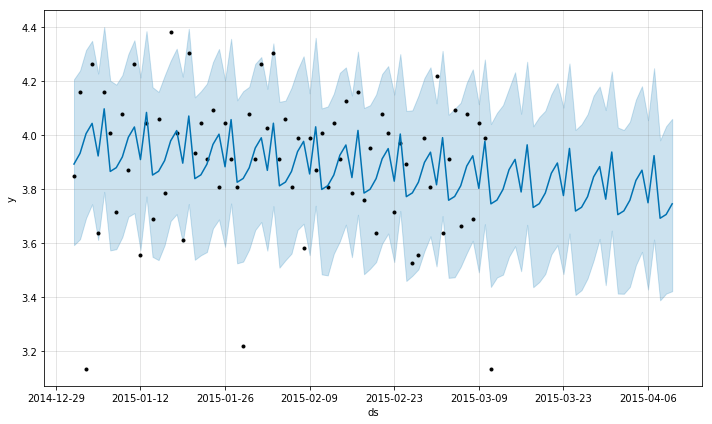

In [19]:
df_ln = np.log(df)
df_ln['ds'] = df_ln.index

mdl_prophet = Prophet()
mdl_prophet.fit(df_ln)

future = mdl_prophet.make_future_dataframe(periods=30)
forecast = mdl_prophet.predict(future)

_ = mdl_prophet.plot(forecast)

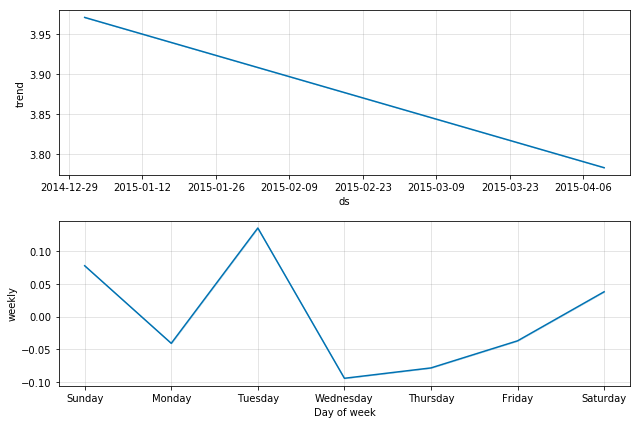

In [20]:
_ = mdl_prophet.plot_components(forecast)

# R

In [24]:
%%R
library(forecast)
library(ggplot2)

df <- read.csv('../data/f_series.csv')
auto.arima(df)

Series: df 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1     ar2     mean
      -0.3407  0.1873  51.2263
s.e.   0.1218  0.1223   1.1007

sigma^2 estimated as 117.8:  log likelihood=-264.83
AIC=537.66   AICc=538.27   BIC=546.65


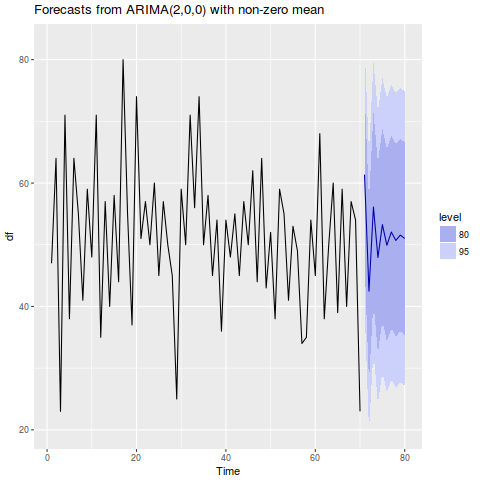

In [25]:
%%R
mdl_r = auto.arima(df)
y_hat = forecast(mdl_r)
autoplot(y_hat)